In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
from skimage.feature import hog
import cv2, os, glob, math

In [2]:
def create_data(filename, px):
    data = []
    for jpg in glob.glob("images/" + filename + "/*.jpg"):
        img = np.array(mpimg.imread(jpg))
        img = cv2.resize(img, (px, px))
        fd = hog(img)
        data.append(fd)
        
    return data

def data_split(rate, array):
    l = len(array)
    n_train = math.floor((1-rate) * l)
    train = array[:n_train]
    test = array[n_train:]
    
    return train, test

def create_label(array, label1, label2):
    l = len(array)
    new_array = []
    for i in range(l):
        if i < l/2:
            new_array.append(label1)
        else:
            new_array.append(label2)
    
    return new_array

In [3]:
data_tigers = create_data("tigers", 64)[:500]
data_dolphins = create_data("dolphins", 64)[:500]

In [4]:
train_tigers, test_tigers = data_split(0.1, data_tigers)
train_dolphins, test_dolphins = data_split(0.1, data_dolphins)
X_train = [*train_tigers, *train_dolphins]
X_test = [*test_tigers, *test_dolphins]
y_train = create_label(X_train, -1, 1)
y_test = create_label(X_test, -1, 1)

In [5]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [6]:
class SVM():
    def __init__(self, lr = 0.0001, lambda_param = 0.01, n_iters = 1000):
        self.lr = lr
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        y_ = np.where(y <= 0, -1, 1)
        
        self.w = np.zeros(n_features)
        self.b = 0
        
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                cond = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if cond:
                    self.w = self.w - self.lr * 2 * self.lambda_param * self.w
                else:
                    self.w = self.w - self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b = self.b - self.lr * y_[idx]
                    
    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)
    
    def score(self, y_pred, y_test):
        return np.sum(y_pred == y_test) / len(y_test)
    

In [7]:
n_iters = [250, 500, 750, 1000, 1250, 1500, 1750, 2000]
loss = []

for n in n_iters:
    svm = SVM(n_iters = n)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    loss.append(1 - svm.score(y_pred, y_test))

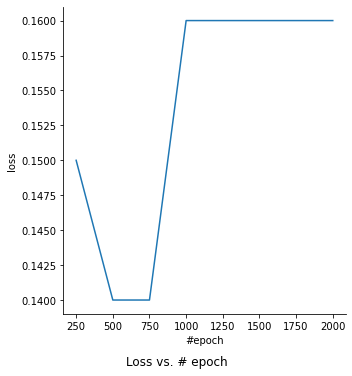

In [8]:
import seaborn as sns
g = sns.relplot(x = n_iters, y = loss, kind = 'line')
g.fig.suptitle('Loss vs. # epoch', y = 0)
g.set(xlabel = '#epoch', ylabel = 'loss')